# Training Gaussian Boson Sampling

We test the boson sampling operator 
on squeezed states, and 
propagating in a random medium

We use a neural network to model the characteristic function

We train the random medium to minimize <(n0-n1)^2> 

A linear interferometer is used as weight

nonlinearxwaves@gmail.com<br>
@version 21 feb 2021

# Setup and import

In [1]:
import numpy as np
from qutip import random_objects
import math
import scipy as scipy
from scipy.linalg import expm, sinm, cosm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import itertools as it

In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = np.complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

Check GPU

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dimension

N is the size of the vector x input to the characteristic functions

In [5]:
N = 12

n is the number of mode, with n=N/2

In [6]:
n=int(N/2)

## Vacuum layer

We define a tf layer that return a Gaussian function with identity covariance matrix and zero displacement

In [7]:
class VacuumLayer(layers.Layer):
    """
        Define a Gaussian state as a neural network layer
    """

    def __init__(self, N=10, dtype=tf_real,**kwargs):
        super(VacuumLayer, self).__init__(**kwargs)
        g_in=np.eye(N, dtype=np_real)
        d_in=np.zeros((N, 1))
        self.N = N
        assert self.N % 2 == 0, \
            " Dimension must be even "
        self.g_np = g_in
        self.d_np = d_in
        self.g = tf.Variable(self.g_np, dtype=self.dtype,
                             trainable=False)
        self.d = tf.Variable(self.d_np, dtype=self.dtype,
                             trainable=False)
        self.DotLayer = tf.keras.layers.Dot(axes=1)


    def call(self, x, di=None): 
        # [chir, chii] = self.call(x,a)
        # [chir, chii] = self.call(x) , here a=0 as default
        # param: x the input row vector (Nbatch, N)
        # param: a the input ancillas column vector (N,1)
        # output: chir, the real part of the characteristic function
        # output: chii, the imaginary part of the characteritic function
        if di is None:
            di1 = tf.constant(np.zeros((self.n, 1)), dtype=tf_real)
        else:
            di1 = di
        yi = tf.matmul(x, self.d+di1)
        yR = tf.matmul(x, self.g, transpose_b=True) # note the transpose here, needed for DotLayer
        gDot = self.DotLayer([x, yR])
        yr2 = tf.multiply(-0.25, gDot)
        return [tf.multiply(tf.exp(yr2),tf.cos(yi)), tf.multiply(tf.exp(yr2),tf.sin(yi))]


Create a vacuum layer object

In [8]:
vacuum = VacuumLayer(N)

# Squeezing layer

Define a linear layer with the symplectic matrix corresponding to a single mode squeezer

In [9]:
def RQRP(n=10):
    """
    Return matrices needed to build the symplectic matrix

     Parameters
     ----------
     n : TYPE, dimension of R (2 times the number of bodies)
         DESCRIPTION. The default is 10.

     Returns
     -------
     The projection matricex RX and RP, and the matrix J

    """
    n2 = np.floor_divide(n, 2)
    RQ = np.zeros((n,n2), dtype = np_real)
    RP = np.zeros((n,n2), dtype = np_real)
    c=-1
    d=-1
    for j in range(n):
        if j%2==0:
            c=c+1
            RQ[j,c]=1.0
        else:
            d=d+1
            RP[j,d]=1.0
    J = np.matmul(RQ, RP.transpose())-\
        np.matmul(RP, RQ.transpose())
    return RQ, RP, J

class SingleModeSqueezer(layers.Layer):
    """
        Define a linear random layer corresponding to a
        single mode squeeze opeator

        In input has input N, the size of the R vector (must be even)

        The parameters r and theta, and the index of the squeezed mode

        nsqueezing goes from 0 to n-1  // index of the squeezed modes

        :param N: dimension of x
        :param r_np : squeezing parameter
        :param theta_np : angle squeezing parameter
        :param n_squeezed : index of the squeezed mode (from 0 to n-1)

        :output x M
        :output b = M^(-1) d

    """

    def __init__(self, N=10, r_np=1.0, 
                    theta_np=0.0, 
                    n_squeezed=0,
                 **kwargs):
        super(SingleModeSqueezer, self).__init__(**kwargs)
        assert N % 2 == 0, \
            " Dimension N must be even "
        assert n_squeezed < N/2 , \
            " Cannot squeeze a mode index bigger than N-1 "
        self.N = N
        self.n_squeezed = n_squeezed        
        # squeezing parameters
        self.theta = tf.Variable(theta_np, dtype=tf_real,trainable=False)                              
        self.r = tf.Variable(r_np, dtype=tf_real,trainable=False)                              
        
        # Build the matrices for the symplectic operator
        Rq, Rp, J = RQRP(N)
        self.Rq = tf.constant(Rq, dtype=tf_real)
        self.Rp = tf.constant(Rp, dtype=tf_real)
        self.J = tf.constant(J, dtype=tf_real)
        
        # Padding vector for the matrix 
        self.paddings = tf.constant([[2*n_squeezed, \
                    self.N-2*(n_squeezed+1)],[2*n_squeezed, self.N-2*(n_squeezed+1)]])
            

    def get_M(self):
        # return the M matrix and its inverse MI
        # Build the symplectiv matrix M
        M11 = tf.math.cosh(self.r)-tf.math.cos(self.theta)*tf.math.sinh(self.r)-1 # substract 1 in the diag elements, as then sum identiy
        M12 = tf.math.sin(-self.theta)*tf.math.sinh(self.r) 
        M21 = tf.math.sin(-self.theta)*tf.math.sinh(self.r) 
        M22 = tf.math.cosh(self.r)+tf.math.cos(self.theta)*tf.math.sinh(self.r)-1
        L1 = tf.stack([M11, M12, M21, M22],0)
        L2 = tf.reshape(L1, (2,2))
        L3 = tf.pad(L2, self.paddings, constant_values=0)
        M = L3+tf.eye(self.N)   
        # Inverse of M
        MI = tf.matmul(tf.matmul(M, self.J), self.J, transpose_a=True)
        return M, MI
    


    def call(self, x, di=None):
        # build M and its inverse       
        M, MI=self.get_M()
        # build 
        if di is None:
            d2 = tf.constant(np.zeros((self.N, 1), dtype=np_real), dtype=tf_real)
        else:
            d2 = di
        return [tf.matmul(x, M), tf.matmul(MI, d2)]


### Parameter for squeezing

In [10]:
r_np=0.88;
theta_np=np.pi/4;

## Haar interferometer

In [11]:
class ConstantHaarLayer(layers.Layer):
    """
        Define a linear random layer corresponding to the
        a = U a
        with U a Haar unitary complex matrix
        In the R space, corresponds to
        x = R x
        In input has input n, the size of the R vector (must be even)

        The Haar unitary matrix is generated by the qutip package (qtip.org)


        :param N: dimension

        :output x M
        :output b = M^(-1) d

    """

    def __init__(self, N=10, **kwargs):
        super(ConstantHaarLayer, self).__init__(**kwargs)
        assert N % 2 == 0, " Dimension must be even "
        self.N = N
        n = np.floor_divide(self.N, 2)
        Rx, Rp, J = RQRP(N)
        self.Rx = tf.constant(Rx, dtype=tf_real)
        self.Rp = tf.constant(Rp, dtype=tf_real)
        self.J = tf.constant(J, dtype=tf_real)
        # generate the haar unitary
        U=random_objects.rand_unitary_haar(n)
        self.U = tf.constant(U.full())
        # return the real and immaginary part
        UR = tf.constant(np.real(U.full()),dtype=tf_real)
        UI = tf.constant(np.imag(U.full()),dtype=tf_real)
        # Build the symplectic matrix M
        M = \
            tf.matmul(self.Rx, tf.matmul(UR, self.Rx, transpose_b=True)) +\
            tf.matmul(self.Rp, tf.matmul(UR, self.Rp, transpose_b=True)) -\
            tf.matmul(self.Rx, tf.matmul(UI, self.Rp, transpose_b=True)) +\
            tf.matmul(self.Rp, tf.matmul(UI, self.Rx, transpose_b=True))
        # Inverse of M
        MI = tf.matmul(tf.matmul(M, self.J), self.J, transpose_a=True)
        self.M=M
        self.MI=MI

    def get_M(self):
        # return the symplectic operator
        return self.M, self.MI

    def call(self, x, di=None):
        # no transpose here for M, as M is already transpose
        if di is None:
            d2 = tf.constant(np.zeros((self.N, 1), dtype=np_real), dtype=tf_real)
        else:
            d2 = di
        return [tf.matmul(x, self.M), tf.matmul(self.MI, d2)]

Creat an Haar layer object

In [12]:
HAAR=ConstantHaarLayer(N)

# Trainable random medium

In [13]:
class RandomLayer(layers.Layer):
    """
        Define a linear random layer corresponding to the
        a = U a
        with U a unitary complex matrix
        In the R space, corresponds to
        x = R x
        In input has input n, the size of the R vector (must be even)

        :param N: dimension
        :param trainable_M: if false M is not trained, default is true

        :output x M
        :output b = M^(-1) d

    """

    def __init__(self, N=10, **kwargs):
        super(RandomLayer, self).__init__(**kwargs)
        assert N % 2 == 0, " Dimension must be even "
        self.trainable_M = True
        self.N = N
        n = np.floor_divide(self.N, 2)
        wr_np = np.random.random((n, n))
        wi_np = np.random.random((n, n))
        self.WR = tf.Variable(wr_np, dtype=tf_real,
                              trainable=self.trainable_M)
        self.WI = tf.Variable(wi_np, dtype=tf_real,
                              trainable=self.trainable_M)
        Rx, Rp, J = RQRP(N)
        self.Rx = tf.constant(Rx, dtype=tf_real)
        self.Rp = tf.constant(Rp, dtype=tf_real)
        self.J = tf.constant(J, dtype=tf_real)


    def call(self, x, di=None):
        # generate symmetric matrix
        HR = self.WR+tf.transpose(self.WR)
        # generate an antisymmetric matrix
        HI = self.WI-tf.transpose(self.WI)
        # exponentiate the Hermitian matrix time the imaginary unit
        U = tf.linalg.expm(tf.complex(-HI, HR))
        # return the real and immaginary part
        UR = tf.math.real(U)
        UI = tf.math.imag(U)
        # Build the symplectic matrix M
        M = \
            tf.matmul(self.Rx, tf.matmul(UR, self.Rx, transpose_b=True)) +\
            tf.matmul(self.Rp, tf.matmul(UR, self.Rp, transpose_b=True)) -\
            tf.matmul(self.Rx, tf.matmul(UI, self.Rp, transpose_b=True)) +\
            tf.matmul(self.Rp, tf.matmul(UI, self.Rx, transpose_b=True))
        # Inverse of M
        MI = tf.matmul(tf.matmul(M, self.J), self.J, transpose_a=True)
        if di is None:
            d2 = tf.constant(np.zeros((self.N, 1), dtype=np_real), dtype=tf_real)
        else:
            d2 = di
        return [tf.matmul(x, M), tf.matmul(MI, d2)]

Random layer object

In [14]:
R=RandomLayer(N)

## Build the model
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [15]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(n):
    x1, a1 = SingleModeSqueezer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=False)(x1,a1)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [16]:
model.input_shape[1]

12

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
constant_haar_layer (ConstantHa [(None, 12), (12, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
random_layer (RandomLayer)      [(None, 12), (12, 1) 72          constant_haar_layer[0][0]        
                                                                 constant_haar_layer[0][1]        
__________________________________________________________________________________________________
single_mode_squeezer (SingleMod [(None, 12), (12, 1) 2           random_layer[0][0]           

# Dummy input for the model
The observables do not deped on x

In [18]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

# Differential photon counter layer for Gaussian states

In [19]:
class CovarianceLayer(layers.Layer):
    """
        Return the covariance of a characteristic function        
        from the derivatives of the model

        Given 
        x as 1xN vector
        d as Nx1 vector
        g as NxN symmetric matrix

        For a Gaussian model one has

        chi(x)=exp(-0.25 x^T g x+i x d)=chi_R+ i chi_I

        d = gradient(chi_I(x)) at x=0

        g(m,n) = -2.0 d^2 chi_R / ( dx_m dx_n)-2.0 (d chi_I / dx_m)( d chi_I/dx_n) 
        with all derivatives evaluate at x=0 and m,n =0,1, ..., N-1

        Hence the matrix g is obtained by the Hessian of the model, 
        which can be calculated by the tf.gradient.jacobian function

        In the constructor:
        param: N: size of the of vector

        In the call
        param: c1: real part of chi
        param: c2: imag part of chi
        param: pullback: model to be derivated wrt x

        Returns
        -------
        param: cov: covariance matrix g (N,N)
        param: ci_x: expected R (=transpose of d) (1,N)
        param: Hessian: Hessian at x =0 (N,N)
    """

    def __init__(self, N, **kwargs):
            super(CovarianceLayer, self).__init__(**kwargs)
            # vector size
            self.N = N
            # constant x0 (not to be trained, x=0 for the derivatives)
            self.x0 = tf.constant(np.zeros((1,self.N)), dtype=self.dtype)

    @tf.function
    def call(self, c1, c2, chi):         
        x = self.x0 
        with tf.GradientTape() as t1:
            t1.watch(x) 
            with tf.GradientTape(persistent=True) as t2: 
                t2.watch(x)
                cr, ci = chi(x)
            cr_x = t2.gradient(cr, x)
            ci_x = t2.gradient(ci, x)
        d2cr= t1.jacobian(cr_x,x) # hessian 
        Hessian = tf.reshape(d2cr, [self.N,self.N])
        cov = -2*(Hessian+tf.matmul(ci_x,ci_x,transpose_a=True))
        del t2  
        return cov, ci_x, Hessian


class DifferentialGaussianLayer(layers.Layer):
    """ Returns mean nj-nk and (nk-nk)^2 for a Gaussian model

        In the constructor:
        param: N: size of the of vector

        In the call
        param: c1: real part of chi
        param: c2: imag part of chi
        param: pullback: model to be derivated wrt x

        Returns
        -------
        param: n : (1,n) tensor with <nj>
        param: dn : (n,n) tensor with <nj-nk>
        param: dn2 : (n,n) tensor with <(nj-nk)^2>

    """

    def __init__(self, N, **kwargs):
            super(DifferentialGaussianLayer, self).__init__(**kwargs)
            # vector size
            self.N = tf.constant(N)
            self.n = tf.constant(np.floor_divide(N,2))
            # covariance layer
            self.covariance = CovarianceLayer(N)
            # constant matrix to extract the modes
            Rq, Rp, _ = RQRP(N)
            self.Rq = tf.constant(Rq, dtype=tf_real)
            self.Rp = tf.constant(Rp, dtype=tf_real)
            # tensors of mixed derivatives
            self.cxx = tf.zeros([1,N],dtype=self.dtype)
            self.cxxyy = tf.zeros([N,N],dtype=self.dtype)

    @tf.function
    def build_differences(self, nb1):
        # build a tensor with the differences
        #
        # param: nb1: tensor with shape (1,n)
        #
        # Returns
        # param: dn: tensor nj-nk with shape (n,n)

        dn = tf.zeros([self.n, self.n], dtype=self.dtype)
        for j in tf.range(self.n):
            nj = tf.gather_nd(nb1, [[0,j]])
            for k in tf.range(j+1, self.n):
                nk = tf.gather_nd(nb1, [[0,k]])
                indices = [[j,k]]
                dn = tf.tensor_scatter_nd_add(dn, indices, nj-nk)
                indices = [[k,j]]
                dn = tf.tensor_scatter_nd_add(dn, indices, -nj+nk)


        return dn

   
    def call(self, c1, c2, chi):
        # c1 and c2 are dummy here, but are needed to make a model with this layer
        # chi is the model

        g, d, hessian = self.covariance(c1, c2, chi)

        cr_2x = tf.reshape(tf.linalg.diag_part(hessian), [1, self.N])
        
        dqq = tf.matmul(cr_2x, self.Rq)
        dpp = tf.matmul(cr_2x, self.Rp)
        lapl = dqq+dpp

        nboson = -0.5*lapl-0.5

        dn = self.build_differences(nboson)

        gdiag = tf.linalg.diag_part(g)
        d2 = tf.square(d)
        d4 = tf.square(d2)

        d2 = tf.squeeze(d2)
        d4 = tf.squeeze(d4)

        gjkjk = tf.square(g)

        gjjkk = tf.tensordot(gdiag,gdiag, axes=0)

        gjjdkdk = tf.tensordot(gdiag, d2, axes =0)

        gkkdjdj = tf.tensordot(d2, gdiag, axes =0)

        dd = tf.squeeze(tf.tensordot(d,d,axes=0)) #[N,N]
        gjkdjdk = tf.multiply(g, dd)

        djdjdkdk = tf.tensordot(d2, d2, axes = 0)

        cr_xxyy= 0.5*gjkjk +0.25*gjjkk+0.5*gjjdkdk+2.0*gjkdjdk+0.5*gkkdjdj+djdjdkdk


        dn2 = tf.zeros([self.n,self.n], dtype=self.dtype)

        for j in tf.range(self.n):
            qj = 2*j
            pj = 2*j+1
            # nabla^4 j
            d_qj4 = tf.gather_nd(cr_xxyy,  [[qj,qj]]) # d_qjqjqjqj
            d_pj4 = tf.gather_nd(cr_xxyy,  [[pj,pj]]) # d_qjqjqjqj
            d_qj2 = tf.gather_nd(cr_2x,  [[0,qj]]) # d_qjqj
            d_pj2 = tf.gather_nd(cr_2x,  [[0,pj]]) # d_pjpj
            n4j = d_qj4+d_pj4+2*d_qj2*d_pj2 #nabla^4_j
            for k in tf.range(j+1,self.n):
                qk = 2*k
                pk = 2*k+1
                # nabla^4 k
                d_qk4 = tf.gather_nd(cr_xxyy,  [[qk,qk]]) # d_qjqjqjqj
                d_pk4 = tf.gather_nd(cr_xxyy,  [[pk,pk]]) # d_qjqjqjqj
                d_qk2 = tf.gather_nd(cr_2x,  [[0,qk]]) # d_qjqj
                d_pk2 = tf.gather_nd(cr_2x,  [[0,pk]]) # d_pjpj
                n4k = d_qk4+d_pk4+2*d_qk2*d_pk2 #nabla^4 k

                # nabla^2_j nabla^2_k
                n2j2k = tf.gather_nd(cr_xxyy, [[qj,qk]])+\
                    tf.gather_nd(cr_xxyy, [[qj,pk]])+\
                    tf.gather_nd(cr_xxyy, [[qk,pj]])+\
                    tf.gather_nd(cr_xxyy, [[pk,pj]])
                # store the final value
                njnk = 0.25*(n4j+n4k)-0.5*n2j2k-0.5
                indices =[[j,k]]
                dn2 = tf.tensor_scatter_nd_add(dn2, indices, njnk)
                indices =[[k,j]]
                dn2 = tf.tensor_scatter_nd_add(dn2, indices, njnk)

        return nboson, dn, dn2


In [20]:
Diff=DifferentialGaussianLayer(N)
nboson, Dn, Dn2 = Diff(chir,chii, model)
HModel = tf.keras.Model(inputs = xin, outputs=[nboson,Dn2])

Print the matrix of <(nj-nk)^2>

In [21]:
n_out,Dn_out=HModel(xtrain)
tf.print(Dn_out)

[[0 4.21387959 4.32355595 3.9454565 4.45358562 2.69194889]
 [4.21387959 0 3.04357052 3.52603722 4.13223362 3.38680649]
 [4.32355595 3.04357052 0 2.25187349 3.59768105 3.88935709]
 [3.9454565 3.52603722 2.25187349 0 4.12029266 3.94680214]
 [4.45358562 4.13223362 3.59768105 4.12029266 0 3.60606432]
 [2.69194889 3.38680649 3.88935709 3.94680214 3.60606432 0]]


Initial differential photons between mode 0 and mode 1

In [22]:
tf.print(tf.gather_nd(Dn_out,[[0,1]]))

[4.21387959]


Photon numbers before training

In [23]:
tf.print(n_out)

[[0.996120453 0.996120691 0.996120691 0.99612093 0.996120691 0.99612]]


Mean number of photons

In [24]:
tf.print(tf.reduce_mean(n_out))

0.996120512


## Model with the target output to train

Model with the custom ouput to train

In [25]:
Dn_out01=tf.gather_nd(Dn2,[[0,1]]) 
train_out=tf.exp(Dn_out01,name='Dn01')
nboson0=tf.gather_nd(nboson,[[0,0]], name='n0')
nboson1=tf.gather_nd(nboson,[[0,1]], name='n1')
Train_model = tf.keras.Model(inputs = xin, outputs=[train_out, nboson0, nboson1]) 

Define the custom loss to train the model for maximum output

In [26]:
def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
    return yp

In [27]:
Train_model.compile(loss=custom_loss, optimizer='Adam')

# Transform model

In [28]:
def partial(j, fun , k):
    # return the partial derivative function of  wrt to k[j]
    # as a function of k, the shape of the output is [[1]]
    #
    # param : j : index of component in range(N)
    # param : fun :  function to be derived
    # param : k : input tensor to fun [1,N]
    #
    # return function with shape [1,] 
    def L(k):
        with tf.GradientTape() as tape:
            tape.watch(k)
            y = fun(k)
        dy = tf.squeeze(tape.gradient(y,k))
        return tf.gather_nd(dy, [[j]])
    return L

def doublepartial(j, fun, k):
    # return the laplacian of fun wrt to k[j]
    #
    # param: j : index of the derived variable
    # param: fun : function to be derivate
    # param: k : input tensor of fun
    #
    # return a scalar with the second derivative
    dy1 = partial(j, fun, k)
    dy2 = partial(j, dy1, k)
    return dy2

def laplacian(modeindex, fun, k):
    # return the laplacian with respect to mode index
    #
    # param: modeindex : index of mode in range(n)
    # param: fun : scalar function to be derived
    # param: k : input tensor
    j = 2*modeindex
    dj0 = doublepartial(j, fun, k)
    dj1 = doublepartial(j+1, fun, k)
    def L(k):
        return dj0(k)+dj1(k)
    return L

def Pr(nbar, Qfun, mydtype=tf_real):
    # Boson sample operator
    # Return the probability of sequence in nbar
    # from the Q-transform of the model in the
    # k-function Qfun
    #
    # param: nbar : a list of n integer, as [2,3]
    # param: Qfun : Q-transform of a model
    #
    # Returns the probability as a scalar tensor
    n=len(nbar)
    N=2*n
    x = tf.Variable(tf.zeros([1, N],dtype=mydtype))
    dm = Qfun
    for j in tf.range(n):
        for _ in tf.range(nbar[j]):
            dm = laplacian(j, dm, x)
    
    nbar_sum=tf.reduce_sum(nbar).numpy()
    scale=1
    for j in range(n):
        nj = nbar[j]
        scale = scale*np.math.factorial(nj)    
    
    scale = scale*np.power(2.0,nbar_sum)
    
    scale = 1.0/scale
    
    out=tf.multiply(tf.constant(scale, dtype=mydtype),dm(x))
    
    
    return out

class QTransformLayer(tf.keras.layers.Layer):
    """ Return a layer for the Q-transform
    Usage
    QLayer = QTransformLayer(N, model)
    kin=tf.keras.layers.Input([N],dtype=model.dtype)
    Q = QLayer(kin)
    Qrho = tf.keras.Model(inputs=kin, outputs=Q) 
    """
    
    def __init__(self, N, model):
        super(QTransformLayer, self).__init__()
        self.N = N
        self.EN = tf.eye(self.N, dtype=self.dtype)
        self.model=model
        
        x0 = tf.zeros([1,N],dtype=model.dtype)
        covlayer = CovarianceLayer(N)
        cr, ci = model(x0)
        cov1, mean_R1, _ = covlayer(cr, ci,model)
        self.g=cov1
        self.d=mean_R1

    def call(self, kin):

        g=self.g
        d=self.d
        A= tf.multiply(0.5,g+self.EN)
        AI = tf.linalg.inv(A)


        scale = tf.math.pow(tf.linalg.det(A), tf.constant(-0.5)) 
        
        k = kin-d
        yR  = tf.matmul(AI, k, transpose_b=True)
        gDot = tf.matmul(-0.5*k, yR)
        f = tf.exp(gDot)
        f = tf.multiply(f,tf.exp(tf.matmul(0.5*kin,kin,transpose_b=True)))
        f = tf.multiply(f, scale)

        return f
        

def getQTransformModel(model):
    """ Return a model with the Qtransform 
    
    Param
    -----
    param: model: model to be transformed

    Returns
    -------
    The vector kin and the model Qrho corresponding
    to the modified Q-representation of the model
    """
    N=model.input_shape[1]
    QLayer = QTransformLayer(N, model)
    kin=tf.keras.layers.Input([N],dtype=model.dtype)
    Q = QLayer(kin)
    Qrho = tf.keras.Model(inputs=kin, outputs=Q) 
    return kin, Qrho


In [29]:
kin, Qrho =getQTransformModel(model)

In [30]:
Qrho.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
q_transform_layer (QTransfor (None, None)              240       
Total params: 240
Trainable params: 72
Non-trainable params: 168
_________________________________________________________________


# All the patterns with max one photon per mode

In [31]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [32]:
ln =patterns(2,n)

Print number of patterns

In [33]:
print(len(ln))

15


Print the patterns

In [34]:
print(ln)

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]


## Make a plot versus the probability

Build an array of photon number sampling

In [35]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' pattern '+repr(ln[nbar]))
    Pn[nbar]=Pr(ln[nbar],Qrho).numpy()
    tf.print('Probability ', Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Sample 0 of 15 pattern (1, 1, 0, 0, 0, 0)
Probability  0.002795807
Sample 1 of 15 pattern (1, 0, 1, 0, 0, 0)
Probability  0.00055140443
Sample 2 of 15 pattern (1, 0, 0, 1, 0, 0)
Probability  0.0064442465
Sample 3 of 15 pattern (1, 0, 0, 0, 1, 0)
Probability  0.006032652
Sample 4 of 15 pattern (1, 0, 0, 0, 0, 1)
Probability  0.026232112
Sample 5 of 15 pattern (0, 1, 1, 0, 0, 0)
Probability  0.015394064
Sample 6 of 15 pattern (0, 1, 0, 1, 0, 0)
Probability  0.007709383
Sample 7 of 15 pattern (0, 1, 0, 0, 1, 0)
Probability  0.0057505593
Sample 8 of 15 pattern (0, 1, 0, 0, 0, 1)
Probability  0.009916859
Sample 9 of 15 pattern (0, 0, 1, 1, 0, 0)
Probability  0.027298404
Sample 10 of 15 pattern (0, 0, 1, 0, 1, 0)
Probability  0.013670439
Sample 11 of 15 pattern (0, 0, 1, 0, 0, 1)
Probability  0.0014739049
Sample 12 of 15 pattern (0, 0, 0, 1, 1, 0)
Probability  0.0053523593
Sample 13 of 15 pattern (0, 0, 0, 1, 0, 1)
Probability  0.00049497746
Sample 14 of 15 pattern (0, 0, 0, 0, 1, 1)
Probabi

Store data for plot

In [36]:
ln2u=ln
Pn2u=Pn

Plot

/home/claudio/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(0.0, 0.07)

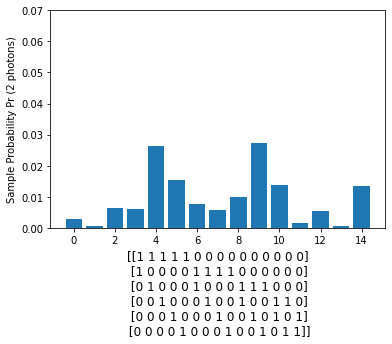

In [37]:
plt.bar(range(len(ln2u)),Pn2u)
plt.xlabel(np.transpose(np.array(ln2u)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');
plt.ylim((0,0.07))

## Patterns with 4 photons

In [38]:
%%time
ln =patterns(4,n)
print("Patterns with 4 photons ",len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' pattern '+repr(ln[nbar]))
    Pn[nbar]=Pr(ln[nbar],Qrho).numpy()
    tf.print("Probability", Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


Patterns with 4 photons  15
Sample 0 of 15 pattern (1, 1, 1, 1, 0, 0)
Probability 0.00074543664
Sample 1 of 15 pattern (1, 1, 1, 0, 1, 0)
Probability 0.00059175567
Sample 2 of 15 pattern (1, 1, 1, 0, 0, 1)
Probability 0.004452444
Sample 3 of 15 pattern (1, 1, 0, 1, 1, 0)
Probability 0.0010165549
Sample 4 of 15 pattern (1, 1, 0, 1, 0, 1)
Probability 0.00035650108
Sample 5 of 15 pattern (1, 1, 0, 0, 1, 1)
Probability 0.001089771
Sample 6 of 15 pattern (1, 0, 1, 1, 1, 0)
Probability 0.0005489159
Sample 7 of 15 pattern (1, 0, 1, 1, 0, 1)
Probability 0.004960047
Sample 8 of 15 pattern (1, 0, 1, 0, 1, 1)
Probability 0.0021354295
Sample 9 of 15 pattern (1, 0, 0, 1, 1, 1)
Probability 0.002142947
Sample 10 of 15 pattern (0, 1, 1, 1, 1, 0)
Probability 0.0016146487
Sample 11 of 15 pattern (0, 1, 1, 1, 0, 1)
Probability 0.0026918112
Sample 12 of 15 pattern (0, 1, 1, 0, 1, 1)
Probability 0.0008748678
Sample 13 of 15 pattern (0, 1, 0, 1, 1, 1)
Probability 0.00062028295
Sample 14 of 15 pattern (0, 0,

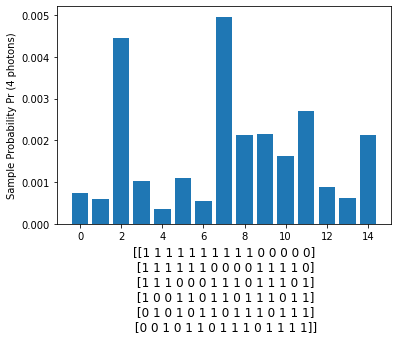

In [39]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');

# Train the model and recompute probabilities

In [40]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=5000,verbose=0)

CPU times: user 52.2 s, sys: 3.66 s, total: 55.9 s
Wall time: 30.6 s


Plot training history

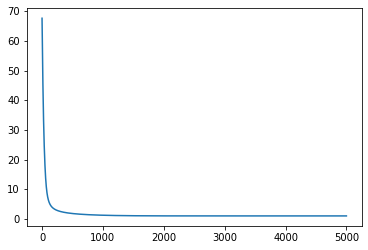

In [41]:
plt.plot(history.history['tf.math.exp_loss'])

Plot the training history in log scale (corresponding to Dn2_01, n0 and n1)

(0.0, 4.0)

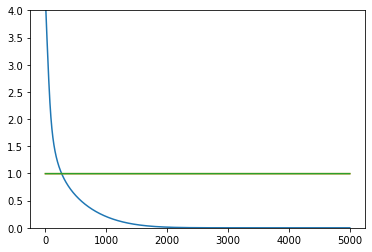

In [42]:
plt.plot(np.log(history.history['tf.math.exp_loss']))
plt.plot(history.history['tf.compat.v1.gather_nd_1_loss'])
plt.plot(history.history['tf.compat.v1.gather_nd_2_loss'])
plt.ylim((0,4.0))

The mean photon number does not change in the modes,
but the difference between the number of photons is zero

## Recompute the transform after the training

In [43]:
kin, Qrho =getQTransformModel(model)

## Patterns with 2 photons

In [44]:
%%time
ln =patterns(2,n)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' pattern  '+repr(ln[nbar]))
    Pn[nbar]=Pr(ln[nbar],Qrho).numpy()
    tf.print('Probability after training ',Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 pattern  (1, 1, 0, 0, 0, 0)
Probability after training  0.062742874
Sample 1 of 15 pattern  (1, 0, 1, 0, 0, 0)
Probability after training  4.1744386e-14
Sample 2 of 15 pattern  (1, 0, 0, 1, 0, 0)
Probability after training  5.3290705e-14
Sample 3 of 15 pattern  (1, 0, 0, 0, 1, 0)
Probability after training  2.0783375e-13
Sample 4 of 15 pattern  (1, 0, 0, 0, 0, 1)
Probability after training  5.151435e-14
Sample 5 of 15 pattern  (0, 1, 1, 0, 0, 0)
Probability after training  1.37667655e-14
Sample 6 of 15 pattern  (0, 1, 0, 1, 0, 0)
Probability after training  5.9063865e-14
Sample 7 of 15 pattern  (0, 1, 0, 0, 1, 0)
Probability after training  2.2604141e-13
Sample 8 of 15 pattern  (0, 1, 0, 0, 0, 1)
Probability after training  5.1292304e-14
Sample 9 of 15 pattern  (0, 0, 1, 1, 0, 0)
Probability after training  0.03625874
Sample 10 of 15 pattern  (0, 0, 1, 0, 1, 0)
Probability after training  0.017633863
Sample 11 of 15 pattern  (0, 0, 1, 0, 0, 1)
Probability after traini

In [45]:
ln2t=ln
Pn2t=Pn

/home/claudio/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(0.0, 0.07)

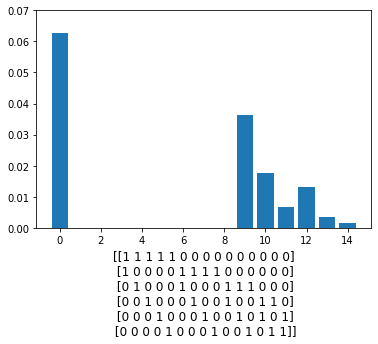

In [46]:
plt.bar(range(len(ln2t)),Pn2t)
plt.xlabel(np.transpose(np.array(ln2t)), fontsize=12);
plt.ylim((0,0.07))

## Patterns of 4 photons

In [49]:
%%time
ln =patterns(4,n)
print("Patterns with 4 photons", len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' pattern '+repr(ln[nbar]))
    Pn[nbar]=Pr(ln[nbar],Qrho).numpy()
    tf.print("Probability after training ",Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Patterns with 4 photons 15
Sample 0 of 15 pattern (1, 1, 1, 1, 0, 0)
Probability after training  0.01809414
Sample 1 of 15 pattern (1, 1, 1, 0, 1, 0)
Probability after training  0.008799801
Sample 2 of 15 pattern (1, 1, 1, 0, 0, 1)
Probability after training  0.0033371837
Sample 3 of 15 pattern (1, 1, 0, 1, 1, 0)
Probability after training  0.0065577887
Sample 4 of 15 pattern (1, 1, 0, 1, 0, 1)
Probability after training  0.0016806284
Sample 5 of 15 pattern (1, 1, 0, 0, 1, 1)
Probability after training  0.0007708381
Sample 6 of 15 pattern (1, 0, 1, 1, 1, 0)
Probability after training  -5.5879257e-09
Sample 7 of 15 pattern (1, 0, 1, 1, 0, 1)
Probability after training  -5.587912e-09
Sample 8 of 15 pattern (1, 0, 1, 0, 1, 1)
Probability after training  -1.0244552e-08
Sample 9 of 15 pattern (1, 0, 0, 1, 1, 1)
Probability after training  -5.587939e-09
Sample 10 of 15 pattern (0, 1, 1, 1, 1, 0)
Probability after training  3.7253214e-09
Sample 11 of 15 pattern (0, 1, 1, 1, 0, 1)
Probability 

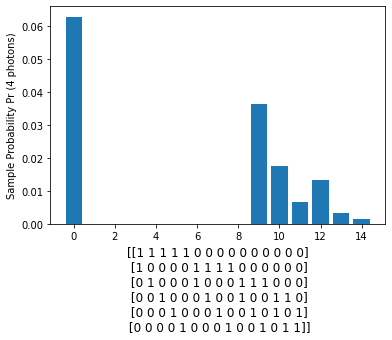

In [48]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr (4 photons)');